# **ENTRENAMIENTO MODELO - Proyecto Final**
## HardVision

**Autor:** Iván Falcón Monzón

In [1]:
# ------------------------------
# 1. Montar Google Drive
# ------------------------------
from google.colab import drive
drive.mount('/content/drive')
# El dataset de entrenamiento esta en Google Drive compartido porque es muy grande para Github: https://drive.google.com/drive/folders/1eT3MkyZ9aWkNkTwvNsLaj6ncebsHt1g8?usp=sharing

Mounted at /content/drive


## Importar librerías necesarías

In [2]:
# ------------------------------
# 2. Instalación de librerías necesarias
# ------------------------------

# Este bloque de código se encarga de instalar las librerías de Python requeridas para el proyecto.

# Instalar la librería 'ultralytics'.
# 'ultralytics' es la librería oficial que proporciona la implementación de los modelos YOLO (You Only Look Once),
# incluyendo YOLOv8, que es el modelo que vamos a entrenar más abajo.
# Contiene funciones para entrenamiento, validación, inferencia y exportación de modelos YOLO.
!pip install ultralytics

# Instalar la librería 'openimages'.
# 'openimages' es una herramienta que facilita el acceso y la descarga de subconjuntos del dataset Open Images.
# Este dataset es una colección muy grande de imágenes con anotaciones de objetos.
!pip install openimages

# Instalar la librería 'fiftyone'.
# 'fiftyone' es una librería de código abierto para construir, evaluar y visualizar datasets
# de visión por computadora. Es extremadamente útil para:
# - Cargar y explorar datasets de imágenes y anotaciones.
# - Visualizar datos de entrenamiento, validación y predicciones.
# - Encontrar y corregir errores en las anotaciones.
# - Filtrar y manipular subconjuntos de datos.
# Es una herramienta útil para la gestión y depuración del dataset durante el ciclo de vida del entrenamiento de un modelo.
!pip install fiftyone

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 55.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 129.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 64.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 105.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

## Importar imagenes para Unknown

In [3]:
# ------------------------------
#  3. Importar imagenes de Open images v6
# ------------------------------
import os # Importa el módulo 'os' para interactuar con el sistema operativo, como crear directorios y manejar rutas de archivos.
import fiftyone.zoo as foz # Importa el módulo 'zoo' de fiftyone con el alias 'foz'. 'fiftyone.zoo' permite cargar y gestionar datasets preexistentes, como Open Images.
from PIL import Image # Importa la clase 'Image' del módulo 'PIL' (Pillow), que se utiliza para abrir, manipular y guardar imágenes.

# Ruta base donde se guardarán las imágenes descargadas para la clase "unknown".
# Estas imágenes se organizarán dentro del dataset de entrenamiento.
output_dir = "/content/drive/MyDrive/CurEspIABD_ProyectoFinal_IvánFalcónMonzón/dataset/train/images/unknown"

# Define una lista de nombres de clases que se descargarán.
# Estas clases se agruparán bajo la categoría "unknown" para el entrenamiento del modelo.
# Esto es útil en escenarios donde ciertas clases no son el objetivo principal de detección
# pero se quiere que el modelo las reconozca como "no relevantes" o "desconocidas".
classes = ["pizza", "cake", "tv", "frisbee", "dog", "microwave", "suitcase", "backpack", "vase", "mouse"]

# Crea el directorio base especificado en 'output_dir' si no existe.
# 'exist_ok=True' evita que se lance un error si el directorio ya existe.
os.makedirs(output_dir, exist_ok=True)

# Define el tamaño al que se redimensionarán todas las imágenes descargadas.
# Homogeneizar el tamaño de las imágenes es una práctica común en el entrenamiento de modelos de visión
# para asegurar una entrada consistente al modelo. YOLOv8 suele trabajar con 640x640.
img_size = (640, 640)

# Itera sobre cada clase definida en la lista 'classes'.
for cls in classes:
    # Construye la ruta del directorio específico para la clase actual dentro de 'output_dir'.
    class_dir = os.path.join(output_dir, cls)
    # Crea el directorio de la clase si no existe.
    os.makedirs(class_dir, exist_ok=True)

    # Verifica si ya existen imágenes en la carpeta de la clase actual.
    # Esto es útil para reanudar descargas o evitar descargas duplicadas.
    # Filtra solo archivos que terminan en extensiones de imagen comunes.
    existing_images = [f for f in os.listdir(class_dir) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
    # Si ya hay 100 o más imágenes en la carpeta, se asume que la descarga para esta clase está completa
    # y se salta a la siguiente clase.
    if len(existing_images) >= 100:
        print(f"Clase '{cls}' ya tiene imágenes. Saltando descarga.")
        continue # Pasa a la siguiente iteración del bucle.

    print(f"Descargando clase: {cls}")

    # Descarga imágenes desde el dataset Open Images V6 usando FiftyOne.
    dataset = foz.load_zoo_dataset(
        "open-images-v6", # Especifica el dataset a cargar.
        split="train", # Descarga imágenes del split de entrenamiento.
        label_types=["classifications"], # Solicita solo etiquetas de clasificación (no bounding boxes).
        classes=[cls], # Filtra para descargar solo imágenes que contengan la clase actual.
        max_samples=100, # Limita la descarga a un máximo de 100 imágenes por clase.
        shuffle=True # Mezcla las imágenes antes de seleccionarlas.
    )

    # Itera sobre cada muestra (imagen) descargada del dataset.
    for sample in dataset:
        img = sample.filepath # Obtiene la ruta del archivo de la imagen descargada.
        img_name = os.path.basename(img) # Extrae el nombre del archivo de la ruta.
        dest_path = os.path.join(class_dir, img_name) # Construye la ruta de destino para guardar la imagen.

        # Verifica si la imagen ya existe en la ruta de destino para evitar sobrescribir.
        if os.path.exists(dest_path):
            continue # Si ya existe, salta a la siguiente imagen.

        try:
            # Abre la imagen usando Pillow.
            with Image.open(img) as im:
                im = im.convert("RGB") # Convierte la imagen a formato RGB para asegurar consistencia (algunas pueden ser RGBA...).
                im = im.resize(img_size) # Redimensiona la imagen al tamaño predefinido (640x640).
                im.save(dest_path, "JPEG") # Guarda la imagen redimensionada en la ruta de destino con formato JPEG.
        except Exception as e:
            # Captura y muestra cualquier error que ocurra durante el procesamiento de una imagen.
            print(f"Error con la imagen {img}: {e}")

    print(f" {cls} terminado.") # Imprime un mensaje cuando la descarga y procesamiento de una clase ha finalizado.

print("¡Todo listo! Imágenes descargadas y organizadas.") # Mensaje final indicando que todo el proceso ha terminado.

Clase 'pizza' ya tiene imágenes. Saltando descarga.
Clase 'cake' ya tiene imágenes. Saltando descarga.
Clase 'tv' ya tiene imágenes. Saltando descarga.
Clase 'frisbee' ya tiene imágenes. Saltando descarga.
Clase 'dog' ya tiene imágenes. Saltando descarga.
Clase 'microwave' ya tiene imágenes. Saltando descarga.
Clase 'suitcase' ya tiene imágenes. Saltando descarga.
Clase 'backpack' ya tiene imágenes. Saltando descarga.
Clase 'vase' ya tiene imágenes. Saltando descarga.
Clase 'mouse' ya tiene imágenes. Saltando descarga.
¡Todo listo! Imágenes descargadas y organizadas.


In [4]:
# ------------------------------
# 4. Generación automática de etiquetas para YOLO (formato txt)
# ------------------------------

# Este bloque de código se encarga de generar archivos de etiquetas en formato YOLO (.txt)
# para las imágenes que fueron descargadas y clasificadas como "unknown".
# Para simplificar, cada imagen se marca como "unknown" (clase 10) con una caja delimitadora
# que ocupa una porción central de la imagen.

import os # Importa el módulo 'os' para interactuar con el sistema de archivos (crear directorios, listar archivos, etc.).
import fiftyone.zoo as foz # Importa fiftyone.zoo, aunque no se usa directamente en este bloque, se mantuvo del código anterior.
from PIL import Image # Importa la clase 'Image' de Pillow para manejar imágenes, aunque en este caso solo se usa para obtener dimensiones.

# Define la ruta raíz donde se guardarán los archivos de etiquetas (.txt).
labels_root = "/content/drive/MyDrive/CurEspIABD_ProyectoFinal_IvánFalcónMonzón/dataset/train/labels/unknown"

# Define el ID de clase para las imágenes "unknown".
# Es crucial que este ID (10 en este caso) coincida con el ID asignado a la clase 'unknown'
# en el archivo de configuración `data.yaml` de YOLOv8.
unknown_class_id = 10  # Debe coincidir con data.yaml

# Crea el directorio donde se guardarán los archivos de etiquetas si no existe.
# 'exist_ok=True' previene errores si el directorio ya ha sido creado.
os.makedirs(labels_root, exist_ok=True)

# Itera sobre cada subcarpeta dentro de 'output_dir'.
# 'output_dir' fue definido en el bloque de código anterior y contiene las imágenes descargadas
# organizadas por sus clases originales (pizza, cake, etc.), que ahora consideramos "unknown".
for class_folder in os.listdir(output_dir):
    # Construye la ruta completa a la carpeta de la clase actual.
    class_folder_path = os.path.join(output_dir, class_folder)

    # Verifica si la entrada actual es realmente un directorio. Si no lo es (por ejemplo, es un archivo),
    # se salta a la siguiente iteración del bucle.
    if not os.path.isdir(class_folder_path):
        continue

    # Itera sobre cada archivo dentro de la carpeta de la clase actual.
    for filename in os.listdir(class_folder_path):
        # Asegura que solo se procesen archivos de imagen (en este caso, JPEG).
        if not filename.lower().endswith(".jpg"):
            continue

        # Construye la ruta completa a la imagen actual.
        image_path = os.path.join(class_folder_path, filename)

        # Genera el nombre del archivo de etiqueta correspondiente.
        # Por ejemplo, para 'imagen.jpg', el archivo de etiqueta será 'imagen.txt'.
        label_filename = os.path.splitext(filename)[0] + ".txt"
        label_path = os.path.join(labels_root, label_filename)

        # Verificación de existencia del archivo de etiqueta
        # Si el archivo de etiqueta (.txt) para esta imagen ya existe, se salta su creación.
        # Esto evita reescribir etiquetas innecesariamente y permite reanudar el proceso.
        if os.path.exists(label_path):
            # print(f"Etiqueta para {filename} ya existe. Saltando.") # Descomentar para ver mensajes
            continue

        # Abrir imagen para obtener dimensiones. Aunque en este caso la caja es fija,
        # en escenarios más complejos las dimensiones son necesarias para normalizar las coordenadas YOLO.
        try:
            with Image.open(image_path) as im:
                width, height = im.size # Obtiene el ancho y alto de la imagen.
        except Exception as e:
            # Si hay un error al abrir la imagen, se imprime un mensaje y se salta a la siguiente.
            print(f"Error con imagen: {image_path} - {e}")
            continue

        # Define las coordenadas y dimensiones de la caja delimitadora en formato YOLO normalizado.
        # YOLO usa (x_center, y_center, width, height) donde todos los valores están normalizados
        # entre 0 y 1, relativos al ancho y alto de la imagen.
        x_center = 0.5 # Centro horizontal de la caja (50% del ancho de la imagen).
        y_center = 0.5 # Centro vertical de la caja (50% del alto de la imagen).
        w = 0.6 # Ancho de la caja (60% del ancho de la imagen).
        h = 0.6 # Alto de la caja (60% del alto de la imagen).

        # Abre el archivo de etiqueta en modo escritura ('w').
        # Si el archivo no existe, lo crea; si existe, lo sobrescribe (aunque la verificación anterior lo evita).
        with open(label_path, "w") as f:
            # Escribe la línea de la etiqueta en el archivo. El formato es:
            # <class_id> <x_center> <y_center> <width> <height>
            f.write(f"{unknown_class_id} {x_center} {y_center} {w} {h}\n")

print("Etiquetas generadas automáticamente para clase 'unknown'.")

Etiquetas generadas automáticamente para clase 'unknown'.


In [5]:
import os # Importa el módulo 'os' para interactuar con el sistema de archivos, como listar directorios.

# Define la ruta al directorio donde se encuentran las etiquetas generadas para la clase "unknown".
labels_dir = "/content/drive/MyDrive/CurEspIABD_ProyectoFinal_IvánFalcónMonzón/dataset/train/labels/unknown"

# Lista todos los archivos en el directorio 'labels_dir' y filtra aquellos que terminan con ".txt".
# Esto crea una lista de todos los archivos de etiquetas YOLO generados.
labels = [f for f in os.listdir(labels_dir) if f.endswith(".txt")]

# Imprime el número total de archivos de etiquetas encontrados en el directorio.
print(f"Total etiquetas en unknown: {len(labels)}")

# Imprime los primeros 5 nombres de archivos de etiquetas como ejemplo,
# lo que permite una verificación rápida de que se han generado los archivos.
print("Ejemplos:", labels[:5])

Total etiquetas en unknown: 100
Ejemplos: ['c4281407137dacc0.txt', 'e8360570bde54a58.txt', '4dfb763cad6e41fd.txt', 'db2a95d178776844.txt', '8c5373a8ee722f31.txt']


## Entrenamiento del modelo

Este entrenamiento con el modelo de YOLOv8 en Google Colab con el entrono de ejecución de GPU-T4 suele tardar entre 45-50 minutos

In [6]:
# ------------------------------
# 5. Entrenamiento del modelo YOLOv8
# ------------------------------

# Importa la clase YOLO de la librería ultralytics.
# Esta clase es la interfaz principal para cargar, entrenar, validar y usar modelos YOLOv8.
from ultralytics import YOLO

# Carga un modelo YOLOv8 pre-entrenado.
# "yolov8n.pt" se refiere a la versión "nano" de YOLOv8, que es la más pequeña y rápida,
# ideal para entornos con recursos limitados o para pruebas iniciales.
# Los modelos pre-entrenados han sido previamente entrenados en grandes datasets (como COCO)
# y ya han aprendido a detectar una amplia variedad de objetos. Esto permite un "fine-tuning"
# más rápido y eficiente para el dataset.
model = YOLO("yolov8n.pt")

# Inicia el proceso de entrenamiento del modelo.
# Se pasan varios argumentos clave para configurar el entrenamiento:
model.train(
    # 'data': Ruta al archivo de configuración YAML de tu dataset.
    # Este archivo 'data.yaml' es crucial porque define:
    # - Las rutas a las carpetas de imágenes de entrenamiento y validación.
    # - Las rutas a las carpetas de etiquetas de entrenamiento y validación.
    # - Los nombres de las clases que el modelo aprenderá a detectar.
    data="/content/drive/MyDrive/CurEspIABD_ProyectoFinal_IvánFalcónMonzón/dataset/data.yaml",

    # 'epochs': Número de épocas (iteraciones completas sobre todo el dataset de entrenamiento).
    # Más épocas pueden llevar a un mejor rendimiento, pero también aumentan el tiempo de entrenamiento
    # y el riesgo de overfitting (que el modelo memorice los datos de entrenamiento en lugar de aprender patrones generales).
    epochs=50,

    # 'imgsz': Tamaño de la imagen de entrada para el modelo durante el entrenamiento.
    # Las imágenes se redimensionarán a este tamaño antes de ser alimentadas a la red.
    # Un tamaño de 640x640 es un estándar común para YOLOv8.
    imgsz=640,

    # 'batch': Tamaño del lote (batch size).
    # Número de imágenes procesadas simultáneamente por el modelo antes de actualizar sus pesos.
    # Un batch size más grande puede acelerar el entrenamiento si tienes suficiente VRAM en la GPU,
    # pero un batch size más pequeño puede ayudar a la generalización en algunos casos.
    batch=16,

    # 'workers': Número de procesos (workers) a usar para la carga de datos.
    # Un mayor número de workers puede acelerar la preparación de los datos de entrada,
    # especialmente si el cuello de botella está en la lectura y preprocesamiento de imágenes.
    workers=2,

    # 'name': Nombre para el directorio donde se guardarán los resultados del entrenamiento (pesos, métricas, gráficos).
    # Esto ayuda a organizar tus experimentos si entrenas múltiples modelos o variaciones.
    name="resultados"
)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 272MB/s]


Ultralytics 8.3.144 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/CurEspIABD_ProyectoFinal_IvánFalcónMonzón/dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=resultados, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, pa

100%|██████████| 755k/755k [00:00<00:00, 92.5MB/s]

Overriding model.yaml nc=80 with nc=11

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytic

Model summary: 129 layers, 3,012,993 parameters, 3,012,977 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 396MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.4±0.1 ms, read: 0.1±0.0 MB/s, size: 65.1 KB)


train: Scanning /content/drive/MyDrive/CurEspIABD_ProyectoFinal_IvánFalcónMonzón/dataset/train/labels... 1733 images, 1100 backgrounds, 0 corrupt: 100%|██████████| 2833/2833 [36:41<00:00,  1.29it/s]


train: New cache created: /content/drive/MyDrive/CurEspIABD_ProyectoFinal_IvánFalcónMonzón/dataset/train/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 14529, len(boxes) = 14751. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.7±0.2 ms, read: 0.1±0.0 MB/s, size: 70.0 KB)


val: Scanning /content/drive/MyDrive/CurEspIABD_ProyectoFinal_IvánFalcónMonzón/dataset/valid/labels.cache... 83 images, 0 backgrounds, 0 corrupt: 100%|██████████| 83/83 [00:00<?, ?it/s]


Plotting labels to runs/detect/resultados/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/resultados
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.09G      1.827      3.162      1.708          0        640: 100%|██████████| 178/178 [01:02<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:13<00:00,  4.59s/it]

                   all         83        869      0.809      0.407      0.458      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.59G      1.498      1.845      1.462          7        640: 100%|██████████| 178/178 [00:56<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]

                   all         83        869      0.714      0.671      0.753      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.59G      1.407       1.61      1.404          6        640: 100%|██████████| 178/178 [00:56<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]

                   all         83        869      0.712      0.724      0.756      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.59G      1.341      1.456      1.363         28        640: 100%|██████████| 178/178 [00:56<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.39it/s]

                   all         83        869      0.778      0.806      0.798      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.59G      1.274      1.331       1.32         12        640: 100%|██████████| 178/178 [00:57<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.31it/s]

                   all         83        869       0.82       0.83      0.861       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.59G      1.226      1.242      1.288          8        640: 100%|██████████| 178/178 [00:56<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.59it/s]

                   all         83        869      0.726       0.85      0.861      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.59G      1.177       1.19      1.248          0        640: 100%|██████████| 178/178 [00:56<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.55it/s]

                   all         83        869      0.844      0.858      0.886      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50       2.6G      1.152      1.112      1.238         14        640: 100%|██████████| 178/178 [00:57<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.85it/s]

                   all         83        869      0.861      0.855      0.889      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.62G      1.119      1.074      1.224         13        640: 100%|██████████| 178/178 [00:56<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.31it/s]


                   all         83        869      0.873      0.858      0.882      0.642

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.64G      1.087      1.026      1.197         10        640: 100%|██████████| 178/178 [00:56<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.23it/s]

                   all         83        869      0.826      0.861      0.888      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.64G      1.075     0.9904      1.187         14        640: 100%|██████████| 178/178 [00:56<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.48it/s]

                   all         83        869      0.911      0.863      0.901       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.64G      1.044     0.9646      1.171         11        640: 100%|██████████| 178/178 [00:57<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.65it/s]


                   all         83        869      0.862      0.883      0.901      0.679

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.64G      1.037      0.949      1.168         21        640: 100%|██████████| 178/178 [00:57<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.73it/s]

                   all         83        869      0.908      0.879      0.903      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.64G      1.026     0.9317      1.166         10        640: 100%|██████████| 178/178 [00:55<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.69it/s]


                   all         83        869      0.883      0.868        0.9      0.691

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.64G      1.003     0.9103       1.15          0        640: 100%|██████████| 178/178 [00:55<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.67it/s]

                   all         83        869      0.903       0.87       0.91      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.64G      1.001     0.8884      1.147         10        640: 100%|██████████| 178/178 [00:55<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.75it/s]

                   all         83        869      0.916      0.888      0.909      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.65G      0.961     0.8669       1.13          2        640: 100%|██████████| 178/178 [00:56<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.55it/s]

                   all         83        869      0.926       0.89      0.918      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.67G     0.9693     0.8704      1.129         10        640: 100%|██████████| 178/178 [00:56<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.30it/s]

                   all         83        869      0.912        0.9      0.912      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.69G      0.957     0.8545      1.129          5        640: 100%|██████████| 178/178 [00:56<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.66it/s]


                   all         83        869      0.911      0.887      0.905      0.702

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.69G     0.9165     0.8241        1.1          0        640: 100%|██████████| 178/178 [00:57<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.64it/s]

                   all         83        869      0.914      0.892      0.908      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.69G     0.9214     0.8101        1.1          0        640: 100%|██████████| 178/178 [00:56<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.43it/s]

                   all         83        869      0.899      0.899      0.911      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.69G     0.9228     0.8093      1.105          7        640: 100%|██████████| 178/178 [00:56<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.71it/s]

                   all         83        869      0.919      0.902      0.915       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.69G     0.9193     0.8106      1.112          2        640: 100%|██████████| 178/178 [00:56<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.79it/s]

                   all         83        869      0.923       0.89      0.901      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.69G     0.9006     0.7797        1.1         27        640: 100%|██████████| 178/178 [00:57<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.67it/s]

                   all         83        869      0.918       0.89      0.913      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.69G     0.9029     0.7718      1.094         24        640: 100%|██████████| 178/178 [00:56<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.44it/s]

                   all         83        869      0.933        0.9      0.915      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.69G     0.8843     0.7613       1.08          0        640: 100%|██████████| 178/178 [00:56<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.68it/s]

                   all         83        869      0.919      0.894      0.917      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.69G     0.8782     0.7533      1.085          8        640: 100%|██████████| 178/178 [00:56<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.75it/s]

                   all         83        869      0.924      0.905      0.916      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.69G     0.8569     0.7514      1.068          0        640: 100%|██████████| 178/178 [00:56<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.55it/s]

                   all         83        869      0.929      0.893      0.917      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.69G     0.8513     0.7484      1.063          0        640: 100%|██████████| 178/178 [00:56<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.37it/s]

                   all         83        869      0.904      0.908      0.913      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.69G     0.8493      0.723      1.065         23        640: 100%|██████████| 178/178 [00:55<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.59it/s]

                   all         83        869      0.925      0.903      0.912      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.69G     0.8365     0.7153      1.064         10        640: 100%|██████████| 178/178 [00:57<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.77it/s]

                   all         83        869      0.928      0.893      0.915      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.69G     0.8302     0.7101      1.057          0        640: 100%|██████████| 178/178 [01:00<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.97it/s]

                   all         83        869      0.926      0.883      0.912      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.69G     0.8326     0.7085      1.055         23        640: 100%|██████████| 178/178 [00:58<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


                   all         83        869      0.912      0.893       0.92      0.746

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.69G     0.8288     0.7007      1.061         12        640: 100%|██████████| 178/178 [00:58<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.18it/s]

                   all         83        869      0.925      0.898       0.93      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.69G     0.8057     0.6914      1.048          0        640: 100%|██████████| 178/178 [01:00<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.23it/s]

                   all         83        869       0.93      0.891       0.93      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.69G     0.7989     0.6849      1.042          7        640: 100%|██████████| 178/178 [01:00<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.27it/s]

                   all         83        869      0.928      0.894      0.928      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.69G     0.7979     0.6738       1.04          8        640: 100%|██████████| 178/178 [01:04<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.68it/s]

                   all         83        869      0.934      0.891      0.912      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.69G     0.7945     0.6668       1.04         11        640: 100%|██████████| 178/178 [01:00<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.48it/s]

                   all         83        869       0.93      0.894      0.927      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.69G     0.7894      0.662      1.037          4        640: 100%|██████████| 178/178 [00:59<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.41it/s]

                   all         83        869      0.927      0.897      0.923       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.69G      0.781     0.6673      1.041         10        640: 100%|██████████| 178/178 [00:59<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]

                   all         83        869      0.935      0.877       0.92      0.767


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.69G     0.7167     0.5785      1.021          7        640: 100%|██████████| 178/178 [00:59<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.54it/s]

                   all         83        869       0.94      0.876      0.924      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.69G     0.6944     0.5781      1.002          1        640: 100%|██████████| 178/178 [00:56<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.29it/s]

                   all         83        869      0.922      0.906      0.914      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.69G     0.6791     0.5529     0.9923          0        640: 100%|██████████| 178/178 [00:56<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.68it/s]

                   all         83        869      0.921      0.913      0.925      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.69G     0.6751     0.5467      1.001          9        640: 100%|██████████| 178/178 [00:54<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]

                   all         83        869      0.934      0.891      0.919      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.69G     0.6708     0.5454     0.9892          9        640: 100%|██████████| 178/178 [00:54<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.96it/s]


                   all         83        869      0.932      0.893      0.921      0.779

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.69G     0.6507       0.53     0.9739          0        640: 100%|██████████| 178/178 [00:53<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.76it/s]

                   all         83        869      0.913      0.907      0.921      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      2.69G     0.6442      0.529     0.9746          0        640: 100%|██████████| 178/178 [00:54<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.19it/s]

                   all         83        869      0.936      0.902      0.919      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.69G      0.646     0.5225     0.9836          9        640: 100%|██████████| 178/178 [00:53<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.06it/s]

                   all         83        869      0.936      0.895       0.92      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.69G     0.6425     0.5214     0.9794         10        640: 100%|██████████| 178/178 [00:53<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.16it/s]

                   all         83        869      0.931      0.904      0.921      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.69G     0.6362     0.5164     0.9723         10        640: 100%|██████████| 178/178 [00:53<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.97it/s]

                   all         83        869      0.925      0.907      0.921       0.79



50 epochs completed in 0.823 hours.
Optimizer stripped from runs/detect/resultados/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/resultados/weights/best.pt, 6.3MB

Validating runs/detect/resultados/weights/best.pt...
Ultralytics 8.3.144 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,007,793 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.26it/s]


                   all         83        869      0.925      0.907      0.921      0.791
               atx_12v         83        164      0.944      0.616      0.722       0.63
             atx_power         81         81          1      0.764      0.898      0.677
                   cpu         46         46      0.933      0.912      0.949      0.914
              cpu-slot         83         83        0.9      0.952      0.965      0.883
           fan-bracket         12         12      0.593      0.851      0.715       0.64
          m.2-ssd-slot         72         72      0.993          1      0.995      0.869
             pcie-slot         83         83      0.993          1      0.995      0.837
                   ram         46         82      0.986          1      0.995      0.873
              ram-slot         83        235      0.948       0.97      0.978      0.736
                   ssd         11         11      0.956          1      0.995      0.849
Speed: 0.4ms preproce

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7c79e7355490>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.0

**Desglose de los Resultados del Entrenamiento**

Proceso de Entrenamiento (Salida durante las Épocas)

Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size      50/

50       2.69G     0.6362     0.5164     0.9723         10        640: 100%|

██████████| 178/178 [00:53<00:00,  3.32it/s]

Esta línea es un resumen del progreso de una época (o un estado intermedio) del entrenamiento.

<br>

Epoch: Indica el número de la época de entrenamiento actual.

- GPU_mem: Muestra la cantidad de memoria de la GPU (en este caso, 2.69 GB) que está siendo utilizada por el proceso de entrenamiento. Esto es útil para monitorear el consumo de recursos.

- box_loss: Es la pérdida de la caja delimitadora (Bounding Box Loss). Mide qué tan bien el modelo está prediciendo la ubicación y el tamaño de los objetos. Un valor más bajo indica que las cajas predichas se ajustan mejor a las cajas reales. En este caso, 0.6362.

- cls_loss: Es la pérdida de clasificación (Classification Loss). Mide qué tan bien el modelo está clasificando correctamente los objetos dentro de las cajas. Un valor más bajo indica una mejor clasificación. Aquí, 0.5164.

- dfl_loss: Es la pérdida DFL (Distribution Focal Loss). Esta es una pérdida específica de YOLOv8 que ayuda a la regresión de las cajas al enfocarse en la calidad de la distribución de los puntos que definen los límites de la caja. Un valor más bajo es mejor. En este caso, 0.9723.

- Instances: El número de instancias (objetos) detectadas o procesadas en este paso/época (10).

- Size: El tamaño de las imágenes que se están procesando (640x640 píxeles).
100%|██████████| 178/178 [00:53<00:00, 3.32it/s]: Esta es una barra de progreso. Indica que se han procesado 178 de 178 lotes (batches) de datos, completando el 100% de la época en 53 segundos, con una tasa de 3.32 iteraciones por segundo.

Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.97it/s]
                   all         83        869      0.925      0.907      0.921       0.795

Esta sección resume las métricas de validación por clase (aunque aquí solo se muestra el promedio "all" para todas las clases) después de una época de entrenamiento.

<br>

- all: Representa las métricas promediadas sobre todas las clases detectables por tu modelo.

- Images: El número de imágenes en el conjunto de validación procesado (83 imágenes).

- Instances: El número total de instancias (objetos reales) en esas imágenes de validación (869 objetos).

- Box(P) (Precision): La precisión promedio para todas las clases. Indica qué proporción de las detecciones del modelo fueron correctas. Un valor de 0.925 (92.5%) es excelente.

- R (Recall): El recall (o exhaustividad) promedio para todas las clases. Indica qué proporción de los objetos reales en las imágenes fueron detectados por el modelo. Un valor de 0.907 (90.7%) también es muy bueno.

- mAP50: El mean Average Precision (mAP) con un umbral de Intersection over Union (IoU) del 50%. Es decir, una detección se considera correcta si su IoU con la verdad terrestre es al menos 0.5. Un mAP50 de 0.921 (92.1%) es un rendimiento muy sólido.

- mAP50-95: El mAP promediado sobre diferentes umbrales de IoU, desde 0.5 hasta 0.95 (en pasos de 0.05). Esta es una métrica más estricta y representativa del rendimiento general. Un mAP50-95 de 0.795 (79.5%) indica que el modelo no solo detecta los objetos, sino que también los localiza con bastante precisión.

<br>

maps: array([    0.63008,     0.67697,     0.91444,     0.88291,     0.

64041,     0.86881,     0.83743,     0.87256,     0.73619,     0.84934,     0.

79091])

Este es un array que probablemente contiene los valores de mAP por clase (en el orden en que las clases están definidas internamente, no necesariamente el orden de names de abajo), y el último valor (0.79091) es el mAP promedio global. Como tienes 11 clases (names tiene 11 entradas), este array muestra el mAP para cada una de tus clases, y el último valor es el promedio.

<br>

names: {0: 'atx_12v', 1: 'atx_power', 2: 'cpu', 3: 'cpu-slot', 4:

'fan-bracket', 5: 'm.2-ssd-slot', 6: 'pcie-slot', 7: 'ram', 8: 'ram-slot', 9:

'ssd', 10: 'unknown'}

Este es un diccionario que mapea los IDs numéricos de las clases a sus nombres legibles. Es crucial para interpretar las predicciones del modelo. Vemos que tienes 11 clases, incluyendo la clase unknown con ID 10, tal como la configuraste.

<br>

Métricas finales de rendimiento del modelo validado en un formato más estructurado:

- metrics/precision(B): Precisión final de 0.9246.

- metrics/recall(B): Recall final de 0.9065.

- metrics/mAP50(B): mAP@0.5 final de 0.9206.

- metrics/mAP50-95(B): mAP@0.5:0.95 final de 0.7909.

- fitness: El valor final de fitness compuesto 0.8038.

Estos valores son muy consistentes con los que se vieron en la tabla de resumen durante el entrenamiento, confirmando un excelente rendimiento.

<br>

**En Resumen**

Los  resultados de entrenamiento muestran que tu modelo YOLOv8n ha alcanzado un rendimiento muy fuerte para la tarea de detección de objetos, con una alta precisión y recall, y un excelente mAP tanto a un umbral bajo (0.5) como a través de un rango de umbrales estrictos (0.5:0.95). La pérdida de las cajas, clasificación y DFL disminuyeron a valores razonables, lo que indica un aprendizaje efectivo.

## Comprobaciones del modelo entrenado


image 1/56 /content/drive/MyDrive/CurEspIABD_ProyectoFinal_IvánFalcónMonzón/dataset/test/images/screenshot_120_jpg.rf.a0dc3485a0ed65b5dca3696a9033d54a.jpg: 640x640 1 cpu-slot, 1 m.2-ssd-slot, 1 pcie-slot, 4 ram-slots, 7.5ms
image 2/56 /content/drive/MyDrive/CurEspIABD_ProyectoFinal_IvánFalcónMonzón/dataset/test/images/screenshot_124_jpg.rf.a76b3566858b48156559d915464c8cf5.jpg: 640x640 1 cpu-slot, 1 m.2-ssd-slot, 1 pcie-slot, 4 ram-slots, 9.6ms
image 3/56 /content/drive/MyDrive/CurEspIABD_ProyectoFinal_IvánFalcónMonzón/dataset/test/images/screenshot_12_jpg.rf.b95bb1f6343811b9f490f22a3343bbd9.jpg: 640x640 1 cpu-slot, 1 m.2-ssd-slot, 1 pcie-slot, 4 ram-slots, 7.6ms
image 4/56 /content/drive/MyDrive/CurEspIABD_ProyectoFinal_IvánFalcónMonzón/dataset/test/images/screenshot_196_jpg.rf.0bf375520c0f987b47f430a42bbb3440.jpg: 640x640 1 cpu-slot, 1 m.2-ssd-slot, 1 pcie-slot, 4 ram-slots, 7.5ms
image 5/56 /content/drive/MyDrive/CurEspIABD_ProyectoFinal_IvánFalcónMonzón/dataset/test/

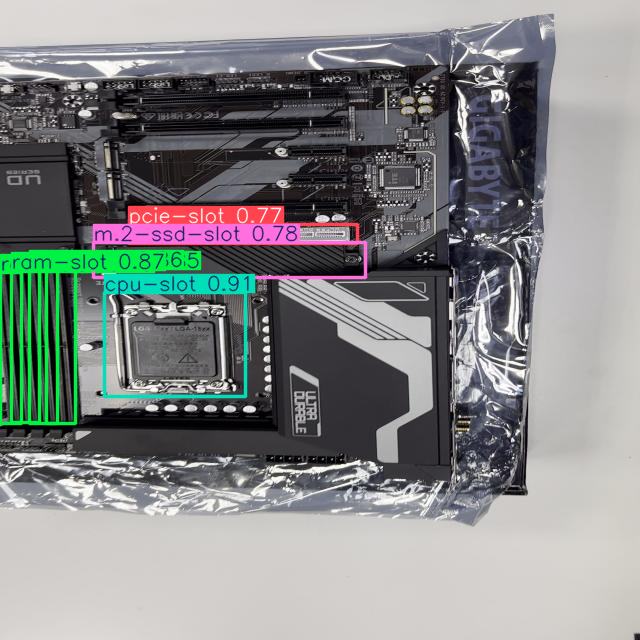

In [9]:
# Cargar el modelo entrenado
# Instancia la clase YOLO y carga los pesos del modelo que fue entrenado previamente.
# La ruta "/content/runs/detect/resultados/weights/best.pt" es la ubicación predeterminada
# donde Ultralytics guarda el modelo con el mejor rendimiento (medido por mAP)
# al final del entrenamiento cuyo nombre de ejecución fue "yolov8n_unknown_train".
model = YOLO("/content/runs/detect/resultados/weights/best.pt")

# Hacer predicciones sobre una imagen o carpeta
# Utiliza el modelo cargado para realizar inferencias (predicciones de objetos).
# 'source': Define la entrada para la predicción.
# ¡IMPORTANTE!: La ruta "/ruta/a/imagenes/de/prueba" es un marcador de posición y DEBE ser reemplazada
# por la ruta real a la imagen o carpeta de imágenes que deseas probar.
# Por ejemplo:
# - Para una imagen específica: 'source="/content/drive/MyDrive/dataset/test/imagen_desconocida.jpg"'
# - Para una carpeta con varias imágenes: 'source="/content/drive/MyDrive/dataset/test_images/"'
# 'imgsz': Especifica el tamaño de la imagen al que se redimensionarán las entradas para la inferencia.
# Debe coincidir con el 'imgsz' utilizado durante el entrenamiento (640 en este caso).
# 'conf': Establece el umbral de confianza. Solo las detecciones con una probabilidad superior
# a este valor (0.3 o 30% en este caso) serán consideradas y mostradas. Ajusta este valor
# para controlar la sensibilidad de las detecciones (menor valor = más detecciones, posiblemente más falsos positivos).
results = model.predict(source="/content/drive/MyDrive/CurEspIABD_ProyectoFinal_IvánFalcónMonzón/dataset/test/images", imgsz=640, conf=0.3)

# Mostrar visualmente
# Accede al primer objeto de resultados (asumiendo que se procesa una sola imagen o que solo se quiere ver la primera).
# El método '.show()' visualiza la imagen con las cajas delimitadoras y etiquetas de las detecciones realizadas.
# Esto abrirá una ventana emergente o mostrará la imagen directamente en la salida de Colab.
results[0].show()

Cada línea representa el resultado de la detección de objetos en una imagen específica.
- image X/56: Indica que esta es la imagen número X de un total de 56 imágenes que se están procesando.
- /content/drive/MyDrive/CurEspIABD_ProyectoFinal_IvánFalcónMonzón/dataset/test/images/screenshot_384_jpg.rf.08456c533f2caaaf264c86ddde749238.jpg: Esta es la ruta completa de la imagen que ha sido procesada. Puedes ver que las imágenes provienen de una carpeta de "test" (prueba) dentro de tu Google Drive.
- 640x640: Confirma que la imagen fue redimensionada a 640x640 píxeles antes de ser pasada al modelo para la inferencia, lo cual es consistente con el tamaño de entrenamiento.
- 1 cpu-slot, 1 m.2-ssd-slot, 1 pcie-slot, 4 ram-slots: Esta es la parte más importante. Enumera los objetos que el modelo ha detectado en la imagen. Por cada detección, muestra:

 - La cantidad de objetos detectados de esa clase (por ejemplo, "1 cpu-slot", "4 ram-slots").

 - El nombre de la clase detectada (por ejemplo, cpu-slot, m.2-ssd-slot, pcie-slot, ram-slots).

- 7.5ms (o similar): Este es el tiempo que tardó el modelo en realizar la inferencia (es decir, en procesar esa imagen y generar las detecciones). Los valores están en milisegundos (ms), lo que indica que el modelo es bastante rápido en sus predicciones.

- Resumen de la última línea: Speed
  - Speed: 2.3ms preprocess, 8.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

  - Esta línea final es un resumen de la velocidad promedio del proceso de inferencia para todo el lote de imágenes (en este caso, las 56 imágenes de prueba).

- 2.3ms preprocess: Tiempo promedio para el preprocesamiento de cada imagen (como redimensionar y normalizar).
- 8.9ms inference: Tiempo promedio que el modelo tarda en hacer la predicción real por cada imagen. Esta es la parte central de la detección.
- 1.8ms postprocess: Tiempo promedio para el postprocesamiento de las salidas del modelo (aplicar umbrales de confianza, Non-Maximum Suppression para eliminar cajas duplicadas, etc.) para obtener las detecciones finales.
per image at shape (1, 3, 640, 640):
 - Indica que estas velocidades son por imagen, con un formato de entrada de (batch_size=1, canales_rgb=3, altura=640, ancho=640).


**Interpretación General**

Estos resultados indican que el modelo está funcionando correctamente, identificando y clasificando los diferentes componentes de las placas base. Las velocidades son muy buenas, lo que sugiere que el modelo es eficiente para aplicaciones en tiempo real o con un alto volumen de procesamiento.

In [10]:
# Muestra los nombres de las clases que el modelo ha sido entrenado para detectar.
# El atributo 'names' de un objeto YOLO contiene un diccionario donde las claves son los IDs de las clases
# y los valores son los nombres legibles de esas clases.
# Esto es fundamental para entender qué es lo que el modelo puede identificar.
print(model.names)

{0: 'atx_12v', 1: 'atx_power', 2: 'cpu', 3: 'cpu-slot', 4: 'fan-bracket', 5: 'm.2-ssd-slot', 6: 'pcie-slot', 7: 'ram', 8: 'ram-slot', 9: 'ssd', 10: 'unknown'}


Este diccionario es fundamental porque establece la correspondencia entre los IDs numéricos (índices) que el modelo utiliza internamente para sus predicciones, y los nombres legibles de las clases de objetos que ha sido entrenado para detectar.


- Claves (números 0 a 10): Son los identificadores únicos que el modelo asigna a cada tipo de objeto. Cuando el modelo detecta algo, devuelve el ID numérico de la clase.
- Valores (nombres como 'atx_12v', 'cpu', 'unknown'): Son las etiquetas humanas que corresponden a esos IDs numéricos.
Por ejemplo:

Si el modelo detecta un objeto y le asigna el ID 2, que se refiere a un 'cpu'.

Si detecta algo con el ID 10, es de la clase 'unknown', que es como esta configurada en la generación de etiquetas. En el archivo data.yaml.

Este mapeo es crucial para la interpretación de los resultados de las predicciones del modelo, ya que te permite entender qué tipo de objeto ha sido detectado en cada imagen.

## Curvas de pérdida del entrenamiento

Este script de Python está diseñado para visualizar las curvas de pérdida del entrenamiento de un modelo YOLOv8 a partir del archivo de resultados generado por Ultralytics.

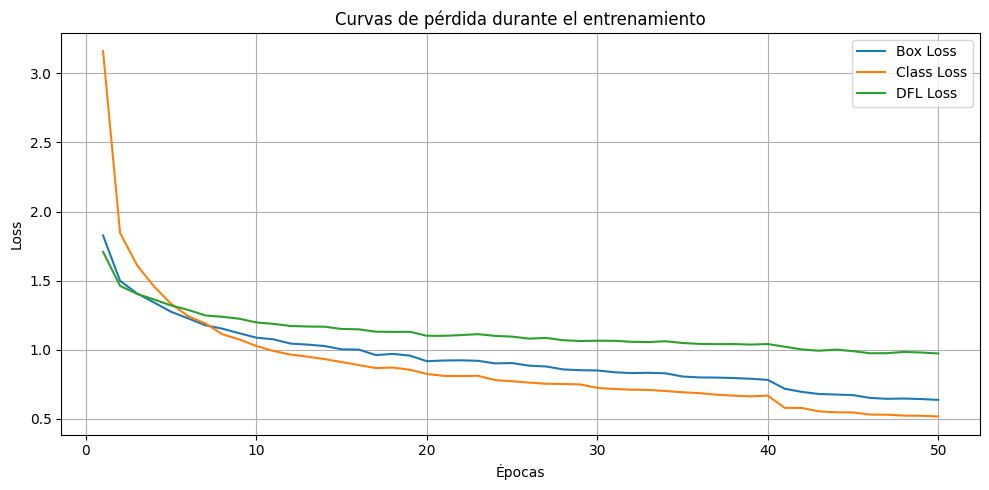

In [12]:
import pandas as pd # Importa la librería pandas, fundamental para el manejo y análisis de datos tabulares, especialmente útil para leer archivos CSV.
import matplotlib.pyplot as plt # Importa el módulo pyplot de matplotlib, que es la librería estándar para la creación de gráficos y visualizaciones en Python.

# Cargar y limpiar columnas
# Carga el archivo CSV de resultados del entrenamiento en un DataFrame de pandas.
# La ruta '/content/runs/detect/resultados/results.csv' es la ubicación por defecto donde Ultralytics guarda
# las métricas de entrenamiento (pérdidas, mAP, etc.) para una ejecución llamada 'train2'.
df = pd.read_csv('/content/runs/detect/resultados/results.csv')
# Limpia los nombres de las columnas eliminando espacios en blanco al principio y al final.
# Esto asegura que puedas acceder a las columnas por sus nombres sin problemas de coincidencia de espacios.
df.columns = df.columns.str.strip()

# Extraer datos
# Extrae las columnas relevantes del DataFrame para la graficación.
# 'epoch': El número de época de entrenamiento.
# 'train/box_loss': La pérdida de la caja delimitadora durante el entrenamiento. Mide la precisión de las coordenadas y dimensiones de las cajas predichas.
# 'train/cls_loss': La pérdida de clasificación durante el entrenamiento. Mide la precisión con la que el modelo clasifica los objetos dentro de las cajas.
# 'train/dfl_loss': La pérdida de DFL (Distribution Focal Loss). Es una pérdida específica de YOLOv8 que mejora la precisión de la regresión de la caja delimitadora.
epochs = df['epoch']
loss_box = df['train/box_loss']
loss_cls = df['train/cls_loss']
loss_dfl = df['train/dfl_loss']

# Graficar
# Crea una nueva figura para el gráfico con un tamaño específico (10 pulgadas de ancho por 5 de alto).
plt.figure(figsize=(10, 5))
# Dibuja la curva de la pérdida de la caja delimitadora ('Box Loss') en función de las épocas.
plt.plot(epochs, loss_box, label='Box Loss')
# Dibuja la curva de la pérdida de clasificación ('Class Loss').
plt.plot(epochs, loss_cls, label='Class Loss')
# Dibuja la curva de la pérdida de DFL ('DFL Loss').
plt.plot(epochs, loss_dfl, label='DFL Loss')
# Establece el título del gráfico.
plt.title('Curvas de pérdida durante el entrenamiento')
# Establece la etiqueta del eje X (épocas).
plt.xlabel('Épocas')
# Establece la etiqueta del eje Y (valor de la pérdida).
plt.ylabel('Loss')
# Muestra una leyenda que identifica cada curva.
plt.legend()
# Añade una cuadrícula al gráfico para facilitar la lectura de los valores.
plt.grid(True)
# Ajusta automáticamente los parámetros de la subtrama para que la figura quepa en el área del dibujo.
plt.tight_layout()
# Muestra el gráfico en pantalla.
plt.show()

Análisis de las Curvas de Pérdida
El gráfico muestra la evolución de tres tipos de pérdida:

1. Box Loss (Azul): Pérdida relacionada con la precisión de las cajas delimitadoras (ubicación y tamaño de los objetos detectados).
2. Class Loss (Naranja): Pérdida relacionada con la precisión de la clasificación de los objetos dentro de las cajas.
3. DFL Loss (Verde): Pérdida específica de YOLOv8 que mejora la calidad de la regresión de las cajas.

**Conclusión sobre el Gráfico de Pérdida:**

El gráfico de curvas de pérdida muestra un entrenamiento exitoso y estable. La disminución constante de las pérdidas es que el modelo está aprendiendo eficazmente a realizar las tareas de detección y clasificación. La caída observada en Class Loss alrededor de la época 40 es un buen signo de optimización.

## Métricas de rendimiento mAP (mean Average Precision)



Este fragmento de código Python tiene como objetivo visualizar las métricas de rendimiento mAP (mean Average Precision) de un modelo YOLOv8 a lo largo del entrenamiento, utilizando los datos de un archivo CSV de resultados.

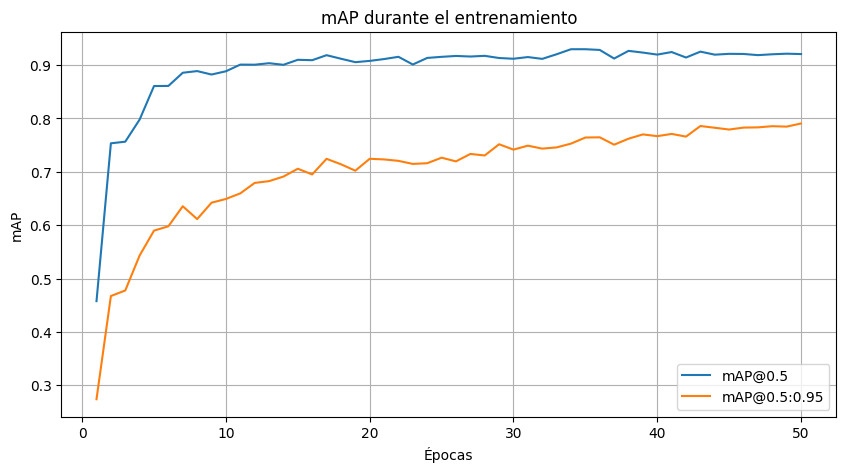

In [13]:
import matplotlib.pyplot as plt # Importa el módulo pyplot de matplotlib para crear gráficos.
# Se asume que 'epochs' y el DataFrame 'df' ya han sido cargados
# y limpiados en el bloque de código anterior, incluyendo la línea:
# df = pd.read_csv('runs/detect/train2/results.csv')
# df.columns = df.columns.str.strip()
# epochs = df['epoch']

# Crea una nueva figura para el gráfico con un tamaño específico (10 pulgadas de ancho por 5 de alto).
plt.figure(figsize=(10, 5))

# Dibuja la curva de mAP@0.5.
# 'df['metrics/mAP50(B)']' accede a la columna del DataFrame que contiene los valores de mAP con un umbral IoU de 0.5.
# '(B)' en el nombre de la columna a menudo se refiere a las métricas calculadas en el conjunto de "Bounding boxes".
plt.plot(epochs, df['metrics/mAP50(B)'], label='mAP@0.5')

# Dibuja la curva de mAP@0.5:0.95.
# 'df['metrics/mAP50-95(B)']' accede a la columna con los valores de mAP promediados sobre diferentes umbrales IoU.
plt.plot(epochs, df['metrics/mAP50-95(B)'], label='mAP@0.5:0.95')

# Establece el título del gráfico.
plt.title('mAP durante el entrenamiento')

# Establece la etiqueta del eje X (épocas).
plt.xlabel('Épocas')

# Establece la etiqueta del eje Y (valor de mAP).
plt.ylabel('mAP')

# Muestra una leyenda para identificar las dos curvas de mAP.
plt.legend()

# Añade una cuadrícula al gráfico para facilitar la lectura de los valores.
plt.grid(True)

# Muestra el gráfico en pantalla.
plt.show()

**Conclusión sobre el Gráfico de mAP:**

El gráfico de mAP confirma que tu modelo ha entrenado de manera muy efectiva. Las métricas de rendimiento son muy altas y consistentes, lo que indica que el modelo es robusto tanto en la identificación de los objetos como en la precisión de sus cajas delimitadoras.

El entrenamiento hasta 50 épocas es positivo, ya que el mAP@0.5:0.95 siguió mejorando hasta el final.

## Curvas de Precisión y Recall

Este bloque de código sirve para visualizar las curvas de Precisión y Recall de tu modelo YOLOv8 durante el entrenamiento, utilizando los datos recopilados en el archivo CSV de resultados.

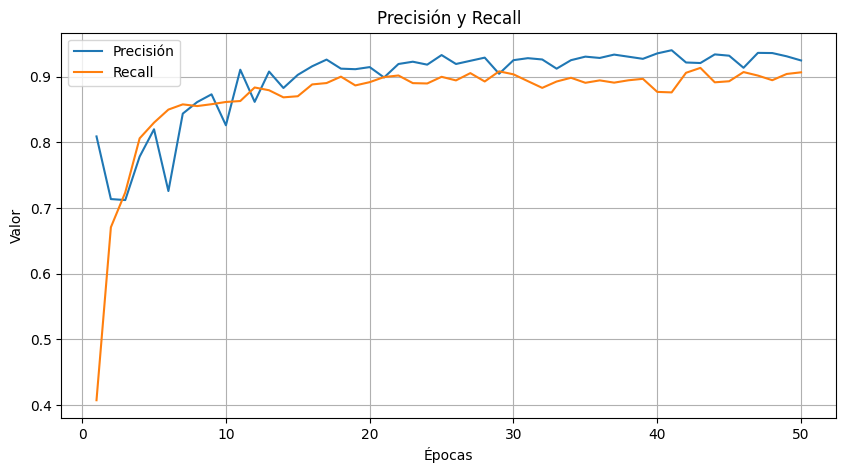

In [14]:
import matplotlib.pyplot as plt # Importa el módulo pyplot de matplotlib para crear gráficos.
# Asumimos que 'epochs' y el DataFrame 'df' ya fueron cargados y limpiados en bloques de código anteriores.

# Crea una nueva figura para el gráfico con un tamaño específico (10 pulgadas de ancho por 5 de alto).
plt.figure(figsize=(10, 5))

# Dibuja la curva de Precisión.
# 'df['metrics/precision(B)']' accede a la columna del DataFrame que contiene los valores de precisión.
# El '(B)' indica que las métricas se calcularon sobre las 'Bounding boxes' (cajas delimitadoras).
plt.plot(epochs, df['metrics/precision(B)'], label='Precisión')

# Dibuja la curva de Recall (Exhaustividad).
# 'df['metrics/recall(B)']' accede a la columna del DataFrame que contiene los valores de recall.
plt.plot(epochs, df['metrics/recall(B)'], label='Recall')

# Establece el título del gráfico.
plt.title('Precisión y Recall')

# Establece la etiqueta del eje X como 'Épocas'.
plt.xlabel('Épocas')

# Establece la etiqueta del eje Y como 'Valor', ya que ambas métricas son valores entre 0 y 1.
plt.ylabel('Valor')

# Muestra una leyenda para diferenciar las curvas de Precisión y Recall.
plt.legend()

# Añade una cuadrícula al gráfico para facilitar la lectura de los valores.
plt.grid(True)

# Muestra el gráfico en pantalla.
plt.show()

**Análisis de las Curvas de Precisión y Recall**

El gráfico muestra la evolución de dos métricas complementarias:

1. Precisión (Azul): Proporción de detecciones positivas que fueron correctas. Responde a "¿De todas las detecciones que hizo mi modelo, cuántas eran realmente objetos?" (pocos falsos positivos).
2. Recall (Naranja): Proporción de objetos positivos reales que fueron correctamente identificados. Responde a "¿Cuántos de los objetos que realmente existen detectó mi modelo?" (pocos falsos negativos).

**Conclusión sobre el Gráfico de Precisión y Recall:**

El modelo ha logrado una precisión y un recall muy  altos, lo que se traduce en un modelo de detección de objetos muy eficaz y fiable. Es capaz de identificar la gran mayoría de los objetos que debería detectar y, al mismo tiempo, las detecciones que realiza son muy pocas veces erróneas.

## 1. Descargar el Modelo Entrenado (best.pt)

Este código permite descargar el archivo de pesos del modelo que tuvo el mejor rendimiento durante el entrenamiento (best.pt).

In [16]:
from google.colab import files
import os

# Define la ruta al archivo de pesos del mejor modelo.
# Asegúrate de que esta ruta coincida con el nombre de tu ejecución de entrenamiento.
# En tu caso, el nombre de la ejecución fue "yolov8n_unknown_train" dentro de "runs/detect".
model_path = "/content/runs/detect/resultados/weights/best.pt"

# Verifica si el archivo existe antes de intentar descargarlo
if os.path.exists(model_path):
    print(f"Descargando el modelo: {model_path}")
    # Usa la función 'files.download' de Google Colab para iniciar la descarga.
    files.download(model_path)
    print("¡Descarga completada!")
else:
    print(f"Error: El archivo del modelo no se encontró en {model_path}")
    print("Asegúrate de que la ruta sea correcta y que el entrenamiento haya finalizado.")

Descargando el modelo: /content/runs/detect/resultados/weights/best.pt


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

¡Descarga completada!


## 2. Guardar la Carpeta runs en Google Drive

La carpeta runs contiene no solo los pesos del modelo, sino también los gráficos de entrenamiento (pérdidas, mAP, etc.), los registros, y otros archivos importantes generados durante el proceso.

In [17]:
import shutil
import os

# Define la ruta de la carpeta 'runs' que quieres guardar.
# Esta carpeta contiene todos los resultados de tus entrenamientos YOLOv8.
source_runs_dir = "/content/runs"

# Define la ruta de destino en tu Google Drive.
# Recomiendo crear una subcarpeta para organizar tus experimentos.
# Por ejemplo, puedes querer guardarlos en una carpeta llamada 'yolov8_experiments' en tu Drive.
destination_drive_dir = "/content/drive/MyDrive/CurEspIABD_ProyectoFinal_IvánFalcónMonzón"

# Asegúrate de que el directorio de destino en Drive exista
os.makedirs(destination_drive_dir, exist_ok=True)

print(f"Copiando la carpeta '{source_runs_dir}' a '{destination_drive_dir}'...")

try:
    # Copia el contenido de la carpeta 'runs' al destino en Google Drive.
    # 'shutil.copytree' copia un directorio completo, incluyendo su contenido.
    # 'dirs_exist_ok=True' permite sobrescribir directorios si ya existen (útil para actualizar resultados).
    shutil.copytree(source_runs_dir, destination_drive_dir, dirs_exist_ok=True)
    print("¡Copia de la carpeta 'runs' a Google Drive completada!")
except Exception as e:
    print(f"Error al copiar la carpeta: {e}")
    print("Verifica que Google Drive esté montado y que las rutas sean correctas.")

Copiando la carpeta '/content/runs' a '/content/drive/MyDrive/CurEspIABD_ProyectoFinal_IvánFalcónMonzón'...
¡Copia de la carpeta 'runs' a Google Drive completada!


## Otros Resultados Obtenidos

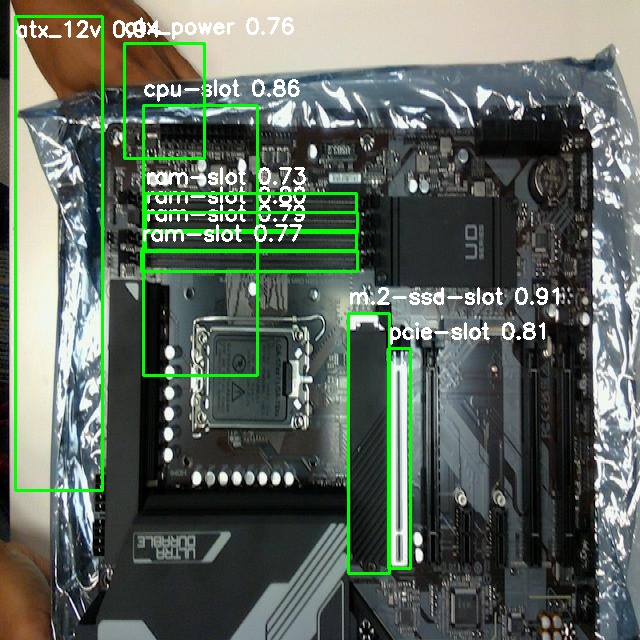

## Repositorios

- Dataset inicial: https://universe.roboflow.com/gradresearch/gradresearch

- Google Colab: https://colab.research.google.com/drive/11X6-vMe4TnmLKkDWmBzcQz4uRGPijMRp?usp=sharing

- Google Drive: https://drive.google.com/drive/folders/1Xzf3wejBUWDtcBH4_ekeg6cCaAUSaqsC?usp=sharing

- Github: https://github.com/IvanFalconMonzon/CurEspIABD_ProyectoFinal_IvanFalconMonzon.git

- Presentación: https://www.canva.com/design/DAGoFF8b7GU/6S5vJ4ckhicu-QaonLDRpg/edit?utm_content=DAGoFF8b7GU&utm_campaign=designshare&utm_medium=link2&utm_source=sharebutton